In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib.pyplot import figure
from matplotlib import gridspec
from sklearn.model_selection import train_test_split

# Turn off Warnings
warnings.filterwarnings("ignore")

# Setup Main Dataset

In [2]:
# Read in full Motor Vehicle Collision Dataset
mvc_df = pd.read_csv('../Motor_Vehicle_Collisions_-_Crashes.csv')

In [3]:
mvc_df.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

In [4]:
# Cleanup dataset
mvc_df['NUMBER OF PERSONS INJURED'].fillna(0, inplace=True)
mvc_df['NUMBER OF PERSONS KILLED'].fillna(0, inplace=True)

# Add Column identifying YEAR
mvc_df['YEAR'] = mvc_df['CRASH DATE'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').year)

# Drop Columns not used for this analysis
mvc_df.drop(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 
             'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 
             'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED'], axis=1, inplace=True)

# Filter to only use the last 5 years of data
mvc_df = mvc_df[mvc_df['YEAR'] > 2018]

In [5]:

mvc_df.head()

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,YEAR,HAS INJURY,HAS FATALITY,CARS INVOLVED
0,2.0,0.0,Aggressive Driving/Road Rage,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN,2021,1,0,2
1,1.0,0.0,Pavement Slippery,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN,2022,1,0,1
2,0.0,0.0,Following Too Closely,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN,2022,0,0,2
3,0.0,0.0,Unspecified,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN,2021,0,0,1
4,0.0,0.0,NaN,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN,2021,0,0,1


# Explore Statistics on the Dataset



In [6]:
# Description Statistics for the Number of Injury and Fatality columns
mvc_df.loc[:,['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED
count,606233.00000,606233.00000
mean,0.40787,0.00210
std,0.76464,0.04792
min,0.00000,0.00000
25%,0.00000,0.00000
50%,0.00000,0.00000
75%,1.00000,0.00000
max,40.00000,4.00000


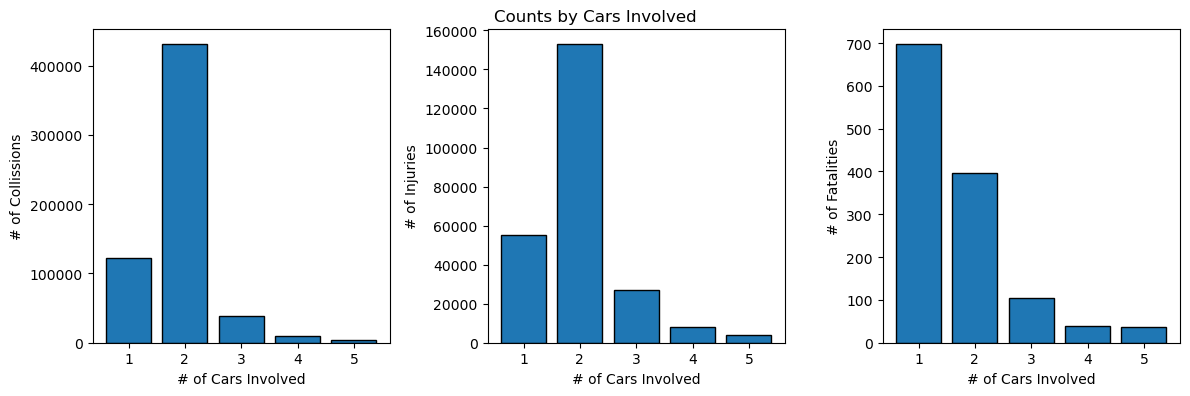

In [7]:
# Identify frequency of CARS INVOLVED
cars_in_col = mvc_df.groupby('CARS INVOLVED')['CARS INVOLVED'].count()
injuries_by_cars = mvc_df.groupby('CARS INVOLVED')['NUMBER OF PERSONS INJURED'].sum()
fatalities_by_cars = mvc_df.groupby('CARS INVOLVED')['NUMBER OF PERSONS KILLED'].sum()

# Define the Grid layout that will hold the graph plots
gs = gridspec.GridSpec(1,3)
fig = plt.figure(figsize=(12,4))

# Plot Accident count by Cars Involved
ax1 = fig.add_subplot(gs[0])
ax1.bar(cars_in_col.index, cars_in_col.values, edgecolor='black')
ax1.set_xlabel('# of Cars Involved')
ax1.set_ylabel('# of Collissions')

ax2 = fig.add_subplot(gs[1])
ax2.bar(injuries_by_cars.index, injuries_by_cars.values, edgecolor='black')
ax2.set_xlabel('# of Cars Involved')
ax2.set_ylabel('# of Injuries')

ax3 = fig.add_subplot(gs[2])
ax3.bar(fatalities_by_cars.index, fatalities_by_cars.values, edgecolor='black')
ax3.set_xlabel('# of Cars Involved')
ax3.set_ylabel('# of Fatalities')

# Pretty up the graphs
fig.tight_layout()
fig.supylabel('')
fig.supxlabel('')
fig.suptitle('Counts by Cars Involved')
fig.subplots_adjust(top=.93)
plt.show()



Both Collissions and Injuries by Cars Involved are right skewed distributions.  
Fatalities by Cars Involved is an exponential distribution.

# Causation Categorization and Accident Datasets

In [8]:
# Import Mapping File that maps Causation Factors to categories
causation_mapping_df = pd.read_csv('causation_factor_mapping_file.csv')

# Function to use for returning the category of a causation factor
def map_causation(cause, mapping_df):
    if (pd.isna(cause) == True):
        return'Unknown'
    category = mapping_df[mapping_df['Causation Factor'] == cause]['Category'].values[0]
    return category

# Create a list of all accidents 
accidents_vc1 = mvc_df.loc[:, ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED','CONTRIBUTING FACTOR VEHICLE 1', 'HAS INJURY', 'HAS FATALITY']]
accidents_vc1.dropna(inplace=True)
accidents_vc1= accidents_vc1.drop(accidents_vc1[accidents_vc1['CONTRIBUTING FACTOR VEHICLE 1'] == 'Other Vehicular'].index)
accidents_vc1['CAUSE CATEGORY'] = accidents_vc1['CONTRIBUTING FACTOR VEHICLE 1'].apply(lambda x: map_causation(x, causation_mapping_df))

accidents_vc2 = mvc_df.loc[:, ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED','CONTRIBUTING FACTOR VEHICLE 2', 'HAS INJURY', 'HAS FATALITY']]
accidents_vc2.dropna(inplace=True)
accidents_vc2 = accidents_vc2.drop(accidents_vc2[accidents_vc2['CONTRIBUTING FACTOR VEHICLE 2'] == 'Unspecified'].index)
accidents_vc2= accidents_vc2.drop(accidents_vc2[accidents_vc2['CONTRIBUTING FACTOR VEHICLE 2'] == 'Other Vehicular'].index)
accidents_vc2['CAUSE CATEGORY'] = accidents_vc2['CONTRIBUTING FACTOR VEHICLE 2'].apply(lambda x: map_causation(x, causation_mapping_df))

accidents_vc3 = mvc_df.loc[:, ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED','CONTRIBUTING FACTOR VEHICLE 3', 'HAS INJURY', 'HAS FATALITY']]
accidents_vc3.dropna(inplace=True)
accidents_vc3= accidents_vc3.drop(accidents_vc3[accidents_vc3['CONTRIBUTING FACTOR VEHICLE 3'] == 'Unspecified'].index)
accidents_vc3= accidents_vc3.drop(accidents_vc3[accidents_vc3['CONTRIBUTING FACTOR VEHICLE 3'] == 'Other Vehicular'].index)
accidents_vc3['CAUSE CATEGORY'] = accidents_vc3['CONTRIBUTING FACTOR VEHICLE 3'].apply(lambda x: map_causation(x, causation_mapping_df))

all_accidents = pd.concat([accidents_vc1, accidents_vc2, accidents_vc3])

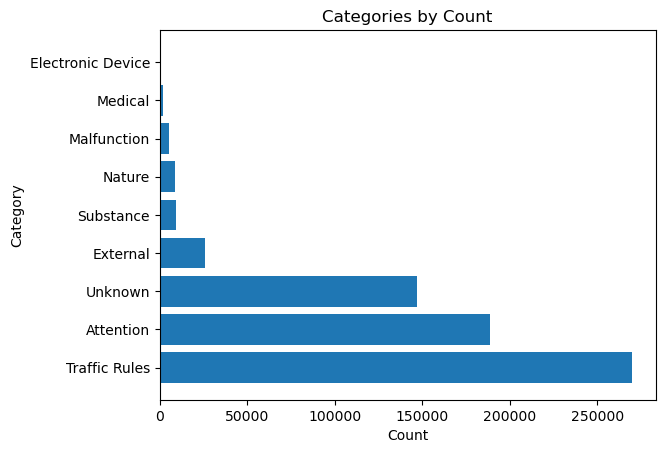

In [60]:
category_counts = all_accidents['CAUSE CATEGORY'].value_counts()
plt.barh(category_counts.index, category_counts.values)
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Categories by Count')
plt.show()

# Chi-Squared and Mosaic Plots for Injuries by Cause Categories

In [25]:
# Create Cross-Tab table for Injuries by Contributing Factor (Counts)
injury_crosstab_df = pd.crosstab(all_accidents['CAUSE CATEGORY'], all_accidents['HAS INJURY'], margins=True, margins_name="Total")

# Sort by number of collissions
injury_crosstab_df.sort_values(injury_crosstab_df.columns[2], ascending = False, inplace=True)

# Output Count Crosstab
print(injury_crosstab_df.to_string())
print('')

# Create Cross-Tab table for Injuries by Contributing Factor (Injury Percentages)
p_injury_crosstab_df = pd.crosstab(all_accidents['CAUSE CATEGORY'], all_accidents['HAS INJURY'], margins=True, margins_name="Total", normalize='index')

# Sort by collission Injury Rate
p_injury_crosstab_df.sort_values(p_injury_crosstab_df.columns[1], ascending = False, inplace=True)

# Output Percentagess Crosstab
print(p_injury_crosstab_df.to_string())

HAS INJURY              0       1   Total
CAUSE CATEGORY                           
Total              454259  203816  658075
Traffic Rules      184330   85418  269748
Attention          127008   61801  188809
Unknown            112065   35094  147159
External            14539   11429   25968
Substance            6073    3289    9362
Nature               5865    3176    9041
Malfunction          3477    1842    5319
Medical               626    1567    2193
Electronic Device     276     200     476

HAS INJURY                0         1
CAUSE CATEGORY                       
Medical            0.285454  0.714546
External           0.559881  0.440119
Electronic Device  0.579832  0.420168
Substance          0.648686  0.351314
Nature             0.648711  0.351289
Malfunction        0.653694  0.346306
Attention          0.672680  0.327320
Traffic Rules      0.683341  0.316659
Total              0.690285  0.309715
Unknown            0.761523  0.238477


In [23]:
# Perform Chi-Squared test, and calculate p-value
chi2_stat, p_value, dof, expected = chi2_contingency(injury_crosstab_df, correction=False)
print("The p-value is: %.5f" % p_value)
print("The chi-squared statistic is: %.2f" % chi2_stat)
print('')

# Create a Table object from the crosstab table
accident_table = sm.stats.Table(injury_crosstab_df)

# Output the Standardized Residuals
print('The standardized residuals are:\n', accident_table.standardized_resids)
print('')

The p-value is: 0.00000
The chi-squared statistic is: 7783.70

The standardized residuals are:
 HAS INJURY                 0          1         Total
CAUSE CATEGORY                                       
Total               0.000000   0.000000  0.000000e+00
Traffic Rules      -6.015136   7.904723  0.000000e+00
Attention         -12.293585  16.155476  0.000000e+00
Unknown            43.128962 -56.677438  0.000000e+00
External          -31.567994  41.484722  0.000000e+00
Substance          -6.007906   7.895222  0.000000e+00
Nature             -5.899702   7.753026  0.000000e+00
Malfunction        -3.977151   5.226527  0.000000e+00
Medical           -28.220679  37.085886  0.000000e+00
Electronic Device  -3.584846   4.710984 -3.685278e-15



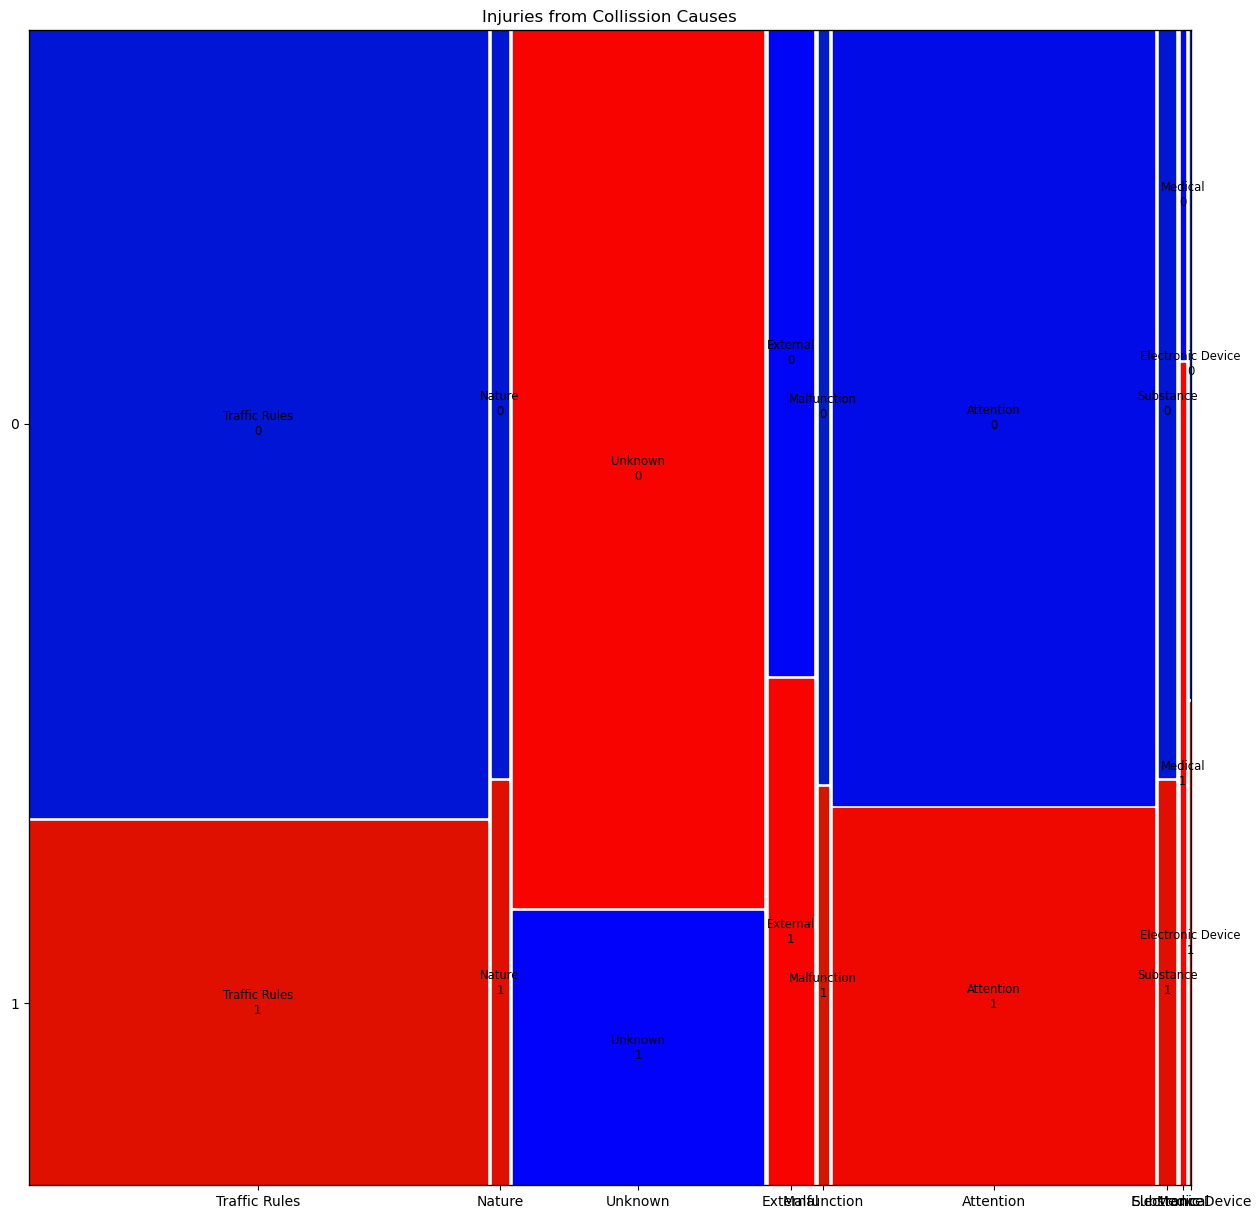

In [20]:
# Generate and Output the Mosaic Plot
fig, ax = plt.subplots(figsize=(15,15))
mosaic(all_accidents, ['CAUSE CATEGORY','HAS INJURY'], statistic=True, title='Injuries from Collission Causes', ax=ax)
plt.show()

The p-value is 0.00, so there is a definite relationship between Cause Factor and Collissions that result in an Injury.  Looking at these Categories in more detail we can see the following:
- Traffic Rule Violations make up 41% of all Collissions, Attention with 29%, and External with 4%
- These three cause categories make up the highest number of collissions with Injuries at 42%, 30%, and 6% respectively.
- Medical, External, and Electronic Devices have the highest Injury Rate with 71%, 44%, 41% respectively.
- Based on the Standardized Residuals, all known Cause Categories have a positive impact on injury rate with External, Medical, and Attention  having the biggest impact.


# Chi-Squared and Mosaic Plots for Fatalities by Cause Categories

In [27]:
# Create Cross-Tab table for Fatalities by Contributing Factor (Counts)
fatality_crosstab_df = pd.crosstab(all_accidents['CAUSE CATEGORY'], all_accidents['HAS FATALITY'], margins=True, margins_name="Total")

# Sort by number of collissions
fatality_crosstab_df.sort_values(fatality_crosstab_df.columns[2], ascending = False, inplace=True)

# Output Count Crosstab
print(fatality_crosstab_df.to_string())
print('')

# Create Cross-Tab table for Fatalities by Contributing Factor (Fatality Percentage)
p_fatality_crosstab_df = pd.crosstab(all_accidents['CAUSE CATEGORY'], all_accidents['HAS FATALITY'], margins=True, margins_name="Total", normalize='index')

# Sort by percentage of collissions that result in fatality
p_fatality_crosstab_df.sort_values(p_fatality_crosstab_df.columns[1], ascending = False, inplace=True)

# Output Crosstab
print(p_fatality_crosstab_df.to_string())


HAS FATALITY            0     1   Total
CAUSE CATEGORY                         
Total              656800  1275  658075
Traffic Rules      269177   571  269748
Attention          188635   174  188809
Unknown            146830   329  147159
External            25892    76   25968
Substance            9311    51    9362
Nature               9025    16    9041
Malfunction          5317     2    5319
Medical              2137    56    2193
Electronic Device     476     0     476

HAS FATALITY              0         1
CAUSE CATEGORY                       
Medical            0.974464  0.025536
Substance          0.994552  0.005448
External           0.997073  0.002927
Unknown            0.997764  0.002236
Traffic Rules      0.997883  0.002117
Total              0.998063  0.001937
Nature             0.998230  0.001770
Attention          0.999078  0.000922
Malfunction        0.999624  0.000376
Electronic Device  1.000000  0.000000


In [28]:
# Perform Chi-Squared test, and calculate p-value
chi2_stat, p_value, dof, expected = chi2_contingency(fatality_crosstab_df, correction=False)

# Interpret p-value
print("The p-value is: %.5f" % p_value)
print("The chi-squared statistic is: %.2f" % chi2_stat)
print('')

# Create a Table object from the crosstab table
fatality_table = sm.stats.Table(fatality_crosstab_df)

# Output the Standardized Residuals
print('The standardized residuals are:\n', fatality_table.standardized_resids)
print('')

The p-value is: 0.00000
The chi-squared statistic is: 824.13

The standardized residuals are:
 HAS FATALITY              0          1     Total
CAUSE CATEGORY                                  
Total              0.000308  -0.009896  0.000308
Traffic Rules     -0.147561   2.368890  0.000156
Attention          0.674661 -10.844296  0.000126
Unknown           -0.171553   2.755226  0.000109
External          -0.227650   3.657790  0.000044
Substance         -0.481997   7.745611  0.000026
Nature             0.022661  -0.364593  0.000026
Malfunction        0.161396  -2.594065  0.000020
Medical           -1.564138  25.136582  0.000013
Electronic Device  0.043608  -0.440504 -0.016198



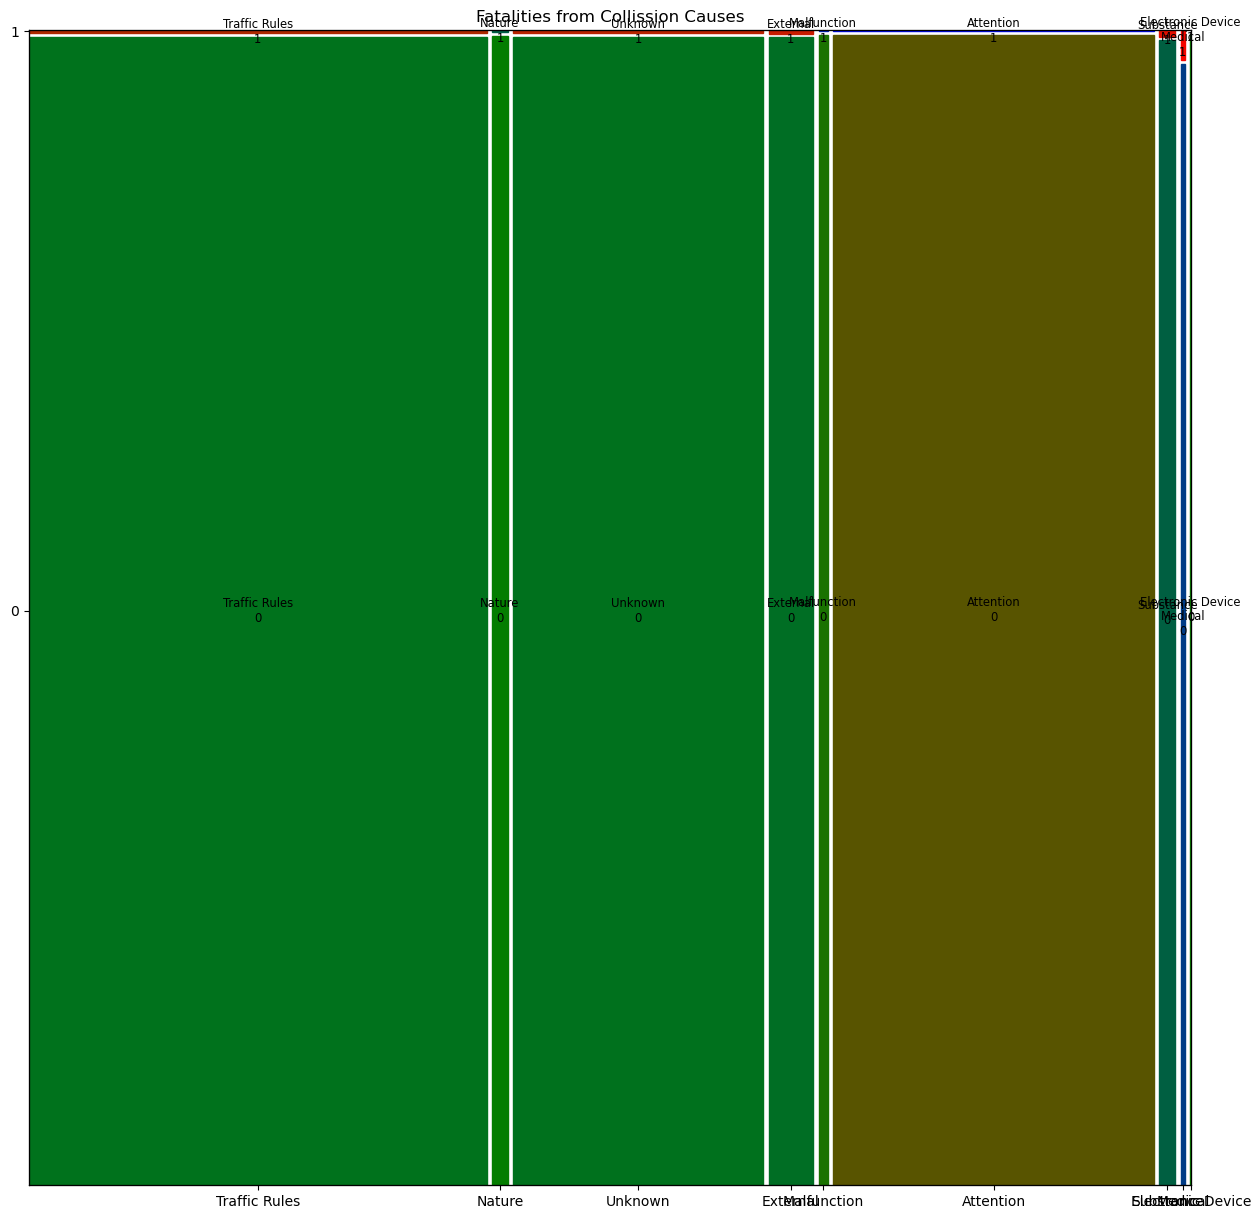

In [33]:
# Generate and Output the Mosaic Plot
fig, ax = plt.subplots(figsize=(15,15))
mosaic(all_accidents, ['CAUSE CATEGORY','HAS FATALITY'], statistic=True, title='Fatalities from Collission Causes', ax=ax )
plt.show()

The p-value is 0.00, so there is a definite relationship between Cause Factor and Collissions that result in an Fatalities.  Looking at these Categories in more detail we can see the following:
- The top 3 Colission causes that result in Fatalities are Traffic Rule Violations (45%), Attention (14%), and External (6%) causes (discounting Unknown Category).
- Medical and Substance have the highest Fatality Rate with 2% and 1% respectively.
- Based on the Standardized Residuals, Medical and Substance causes have the highest impact on Fatality.  

# Chi-Squared and Mosaic Plots for Injuries by # of Cars Involved

In [36]:
# Create Cross-Tab table for Injuries by Number of Cars Invovled (Counts)
num_cars_injury_crosstab_df = pd.crosstab(mvc_df['CARS INVOLVED'], mvc_df['HAS INJURY'], margins=True, margins_name="Total")

# Sort by percentage of collissions that result in injury
num_cars_injury_crosstab_df.sort_values(num_cars_injury_crosstab_df.columns[1], ascending = False, inplace=True)

# Output Crosstab
print(num_cars_injury_crosstab_df.to_string())
print('')

# Create Cross-Tab table for Injuries by Number of Cars Invovled (Injury Percentage)
p_num_cars_injury_crosstab_df = pd.crosstab(mvc_df['CARS INVOLVED'], mvc_df['HAS INJURY'], margins=True, margins_name="Total", normalize='index')

# Sort by percentage of collissions that result in fatality
p_num_cars_injury_crosstab_df.sort_values(p_num_cars_injury_crosstab_df.columns[1], ascending = False, inplace=True)

# Output Crosstab
print(p_num_cars_injury_crosstab_df.to_string())

HAS INJURY          0       1   Total
CARS INVOLVED                        
Total          422288  183945  606233
2              319239  112065  431304
1               72323   50146  122469
3               23447   15675   39122
4                5264    4171    9435
5                2015    1888    3903

HAS INJURY            0         1
CARS INVOLVED                    
5              0.516270  0.483730
4              0.557923  0.442077
1              0.590541  0.409459
3              0.599330  0.400670
Total          0.696577  0.303423
2              0.740172  0.259828


In [41]:
# Perform Chi-Squared test, and calculate p-value
chi2_stat, p_value, dof, expected = chi2_contingency(num_cars_injury_crosstab_df, correction=False)

# Interpret p-value
print("The p-value is: %.15f" % p_value)
print("The chi-squared statistic is: %.2f" % chi2_stat)
print('')

# Create a Table object from the crosstab table
num_cars_table = sm.stats.Table(num_cars_injury_crosstab_df)

# Output the Standardized Residuals
print('The standardized residuals are:\n', num_cars_table.standardized_resids)
print('')

The p-value is: 0.000000000000000
The chi-squared statistic is: 13602.22

The standardized residuals are:
 HAS INJURY             0          1         Total
CARS INVOLVED                                    
Total           0.000000   0.000000  0.000000e+00
2              52.939090 -70.306056  1.561592e-13
1             -58.086523  77.142133  0.000000e+00
3             -29.019872  38.540004  0.000000e+00
4             -20.067294  26.650482  0.000000e+00
5             -16.745611  22.239102  0.000000e+00



The p-value is 0.00, so there is a definite relationship between the Number of Cars involved in a Collission, and those that result in Injuries.  Looking at this in more detail we can see the following:
- Collissions 2 cars make up 71% of collissions, and 61 % of collissions that result in Injuries.
- Colissions with 1 car make up 20% of colissions, and 27% of collissions that result in Injuries.
- Collissions with 5 and 4 cars involved have the highest injury rate with 48% and 44% respectively.
- Based on the Standardized Residuals, 1 car and 3 cars have the highest impact on collissions that result in Injuries.
- Surprisingly, 2 cars has a strong negative residual (likely due to the much higher number of accidents that don't result in an injury compared to the higher injury rate and lower count of 4 and 5 car collissions).

# Chi-Squared and Mosaic Plots for Injuries by # of Cars Involved

In [40]:
# Create Cross-Tab table for Fatalities by Number of Cars Invovled (Counts)
num_cars_fatality_crosstab_df = pd.crosstab(mvc_df['CARS INVOLVED'], mvc_df['HAS FATALITY'], margins=True, margins_name="Total")

# Sort by percentage of collissions that result in fatality
num_cars_fatality_crosstab_df.sort_values(num_cars_fatality_crosstab_df.columns[1], ascending = False, inplace=True)

# Output Crosstab
print(num_cars_fatality_crosstab_df.to_string())
print('')

# Create Cross-Tab table for Injuries by Number of Cars Invovled (Injury Percentage)
p_num_cars_fatality_crosstab_df = pd.crosstab(mvc_df['CARS INVOLVED'], mvc_df['HAS FATALITY'], margins=True, margins_name="Total", normalize='index')

# Sort by percentage of collissions that result in fatality
p_num_cars_fatality_crosstab_df.sort_values(p_num_cars_fatality_crosstab_df.columns[1], ascending = False, inplace=True)

# Output Crosstab
print(p_num_cars_fatality_crosstab_df.to_string())

HAS FATALITY        0     1   Total
CARS INVOLVED                      
Total          605009  1224  606233
1              121791   678  122469
2              430925   379  431304
3               39023    99   39122
4                9399    36    9435
5                3871    32    3903

HAS FATALITY          0         1
CARS INVOLVED                    
5              0.991801  0.008199
1              0.994464  0.005536
4              0.996184  0.003816
3              0.997469  0.002531
Total          0.997981  0.002019
2              0.999121  0.000879


In [42]:
# Perform Chi-Squared test, and calculate p-value
chi2_stat, p_value, dof, expected = chi2_contingency(num_cars_injury_crosstab_df, correction=False)

# Interpret p-value
print("The p-value is: %.15f" % p_value)
print("The chi-squared statistic is: %.2f" % chi2_stat)
print('')

# Create a Table object from the crosstab table
num_cars_fatality_table = sm.stats.Table(num_cars_fatality_crosstab_df)

# Output the Standardized Residuals
print('The standardized residuals are:\n', num_cars_fatality_table.standardized_resids)
print('')

The p-value is: 0.000000000000000
The chi-squared statistic is: 13602.22

The standardized residuals are:
 HAS FATALITY          0          1         Total
CARS INVOLVED                                   
Total          0.000000   0.000000  0.000000e+00
1             -1.835828  28.904438  0.000000e+00
2              1.319438 -20.774073  1.561592e-13
3             -0.145449   2.290042  0.000000e+00
4             -0.247756   3.900822  0.000000e+00
5             -0.546877   8.610372  0.000000e+00



The p-value is 0.00, so there is a definite relationship between the Number of Cars invovled in a Collission, and those that result in Fatalities.  Looking at this in more detail we can see the following:
- Collissions with 1 car make up 55% of collissions that result in fatalities.
- Colissions with 2 cars make up 31% of collissions that result in fatalities.
- Collissions with 5 cars and 1 car involved have the highest fatality rate with .8% and .5% respectively.
- Based on the Standardized Residuals, 1 car and 5 cars have the highest impact on collissions that result in Fatalities.
- Again the 2 cars has a strong negative residual (likely due to the much higher number of accidents that don't result in a fatality).

## Analyze Vehicle Types
#### TODO:
- Categorize Vehicle Types
- Create Crosstab and Perform Chi-Squared test

In [43]:
id_vars = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'HAS INJURY', 'HAS FATALITY']
value_vars = ['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3']
vehicle_types = pd.melt(mvc_df, id_vars=id_vars, value_vars=value_vars, var_name='VEHICLE TYPES SOURCE', value_name='VEHICLE TYPES')
vehicle_types.dropna(inplace=True)
vehicle_types.head()

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,HAS INJURY,HAS FATALITY,VEHICLE TYPES SOURCE,VEHICLE TYPES
0,2.0,0.0,1,0,VEHICLE TYPE CODE 1,Sedan
1,1.0,0.0,1,0,VEHICLE TYPE CODE 1,Sedan
2,0.0,0.0,0,0,VEHICLE TYPE CODE 1,Sedan
3,0.0,0.0,0,0,VEHICLE TYPE CODE 1,Sedan
5,0.0,0.0,0,0,VEHICLE TYPE CODE 1,Dump


In [45]:
vehicle_types['VEHICLE TYPES'] = vehicle_types['VEHICLE TYPES'].str.lower()

vehicle_types_in_col = vehicle_types.groupby('VEHICLE TYPES')['VEHICLE TYPES'].count()
vehicle_types_in_col.sort_values(ascending=False, inplace=True)
vehicle_types_in_col.head(60)
print('Number of Collissions: ' , len(vehicle_types))

Number of Collissions:  1082603


In [58]:
# Identify frequency of Vehicle Types
vehicle_types_in_col = vehicle_types.groupby('VEHICLE TYPES')['VEHICLE TYPES'].count()
injuries_by_vehicle_type = vehicle_types.groupby('VEHICLE TYPES')['NUMBER OF PERSONS INJURED'].sum()
fatalities_by_vehicle_type = vehicle_types.groupby('VEHICLE TYPES')['NUMBER OF PERSONS KILLED'].sum()

top_vehicle_types_in_col = vehicle_types_in_col.sort_values(ascending=False).head(10)
top_vehicle_types_injuries = injuries_by_vehicle_type.sort_values(ascending=False).head(10)
top_vehicle_types_fatalities = (fatalities_by_vehicle_type.sort_values(ascending=False).head(15))
                                
print(top_vehicle_types_in_col)
print('')
print(sum(top_vehicle_types_in_col) / sum(vehicle_types_in_col))
print('')
print(top_vehicle_types_injuries)
print('')
print(sum(top_vehicle_types_injuries) / sum(injuries_by_vehicle_type))
print('')
print(top_vehicle_types_fatalities)
print('')
print(sum(top_vehicle_types_fatalities) / sum(fatalities_by_vehicle_type))

VEHICLE TYPES
sedan                                  486221
station wagon/sport utility vehicle    384146
taxi                                    34282
pick-up truck                           29069
bike                                    25802
box truck                               25045
bus                                     18752
tractor truck diesel                     9299
motorcycle                               8318
e-bike                                   8090
Name: VEHICLE TYPES, dtype: int64

0.9505090970558921

VEHICLE TYPES
sedan                                  209398.0
station wagon/sport utility vehicle    159779.0
bike                                    22053.0
taxi                                    15200.0
pick-up truck                            9176.0
e-bike                                   7143.0
bus                                      6669.0
motorcycle                               6188.0
box truck                                5510.0
e-scooter                

# Modeling Playground

In [61]:
all_accidents.head()

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,HAS INJURY,HAS FATALITY,CAUSE CATEGORY,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3
0,2.0,0.0,Aggressive Driving/Road Rage,1,0,Traffic Rules,NaN,NaN
1,1.0,0.0,Pavement Slippery,1,0,Nature,NaN,NaN
2,0.0,0.0,Following Too Closely,0,0,Traffic Rules,NaN,NaN
3,0.0,0.0,Unspecified,0,0,Unknown,NaN,NaN
5,0.0,0.0,Unspecified,0,0,Unknown,NaN,NaN


In [62]:
all_accidents = pd.get_dummies(all_accidents, columns = ['CAUSE CATEGORY'])
all_accidents.head()

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,HAS INJURY,HAS FATALITY,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CAUSE CATEGORY_Attention,CAUSE CATEGORY_Electronic Device,CAUSE CATEGORY_External,CAUSE CATEGORY_Malfunction,CAUSE CATEGORY_Medical,CAUSE CATEGORY_Nature,CAUSE CATEGORY_Substance,CAUSE CATEGORY_Traffic Rules,CAUSE CATEGORY_Unknown
0,2.0,0.0,Aggressive Driving/Road Rage,1,0,NaN,NaN,0,0,0,0,0,0,0,1,0
1,1.0,0.0,Pavement Slippery,1,0,NaN,NaN,0,0,0,0,0,1,0,0,0
2,0.0,0.0,Following Too Closely,0,0,NaN,NaN,0,0,0,0,0,0,0,1,0
3,0.0,0.0,Unspecified,0,0,NaN,NaN,0,0,0,0,0,0,0,0,1
5,0.0,0.0,Unspecified,0,0,NaN,NaN,0,0,0,0,0,0,0,0,1


In [110]:
# Create X - assign independent variables, dependent variable, respectively
x = all_accidents.loc[:, ['CAUSE CATEGORY_Attention', 'CAUSE CATEGORY_Electronic Device', 'CAUSE CATEGORY_External', 'CAUSE CATEGORY_Malfunction', 'CAUSE CATEGORY_Nature', 'CAUSE CATEGORY_Substance', 'CAUSE CATEGORY_Traffic Rules', 'CAUSE CATEGORY_Unknown']]

# define the target
y = pd.DataFrame(all_accidents['NUMBER OF PERSONS INJURED'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

197423 197423 460652 460652


In [112]:
x_train = sm.add_constant(x_train.loc[:, x_train.columns != 'CAUSE CATEGORY_Unknown'])
model = sm.OLS(y_train, x_train).fit()
print(model.summary())

glm_binom_model = sm.GLM(y_train, x_train, family=sm.families.Poisson()).fit()
print(glm_binom_model.summary())


                                OLS Regression Results                               
Dep. Variable:     NUMBER OF PERSONS INJURED   R-squared:                       0.006
Model:                                   OLS   Adj. R-squared:                  0.006
Method:                        Least Squares   F-statistic:                     396.9
Date:                       Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                               10:47:25   Log-Likelihood:            -5.4014e+05
No. Observations:                     460652   AIC:                         1.080e+06
Df Residuals:                         460644   BIC:                         1.080e+06
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

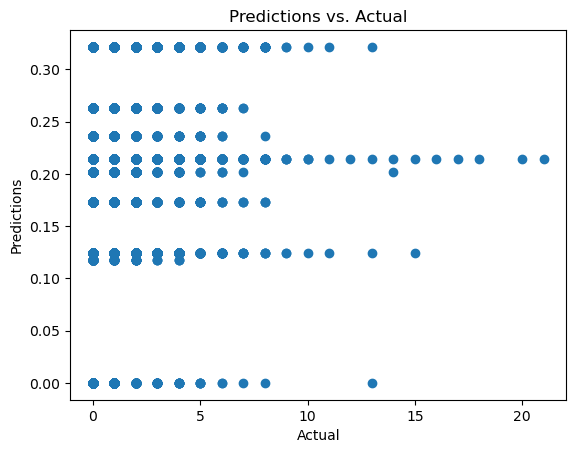

        NUMBER OF PERSONS INJURED
318310                        0.0
310216                        1.0
245967                        0.0
17302                         0.0
341626                        0.0
464517                        0.0
490351                        0.0
81857                         1.0
492630                        0.0
123951                        1.0
318310    0.321344
310216    0.124242
245967    0.213788
17302     0.213788
341626    0.213788
464517    0.213788
490351    0.213788
81857     0.321344
492630    0.321344
123951    0.321344
dtype: float64


In [113]:
ols_predictions = model.predict(x_test)
pd.DataFrame(ols_predictions, columns=['Predictions'])

plt.scatter(y_test, ols_predictions)
plt.title('Predictions vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()

print(y_test.head(10))
print(ols_predictions.head(10))

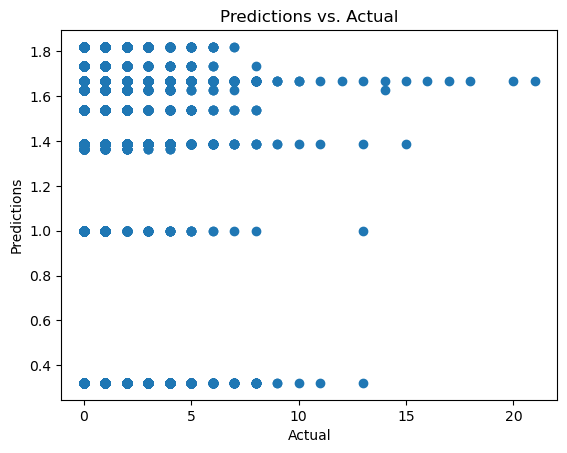

        NUMBER OF PERSONS INJURED
318310                        0.0
310216                        1.0
245967                        0.0
17302                         0.0
341626                        0.0
464517                        0.0
490351                        0.0
81857                         1.0
492630                        0.0
123951                        1.0
318310    0.321344
310216    1.386634
245967    1.665294
17302     1.665294
341626    1.665294
464517    1.665294
490351    1.665294
81857     0.321344
492630    0.321344
123951    0.321344
dtype: float64


In [114]:
glm_predictions = glm_binom_model.predict(x_test)
pd.DataFrame(glm_predictions, columns=['Predictions'])

plt.scatter(y_test, glm_predictions)
plt.title('Predictions vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()

print(y_test.head(10))
print(glm_predictions.head(10))